Part 4 of my Pyspark series.
This part is going to be analysing Remote work trends:

Remote Work Distribution by Country and Region:

Objective 1 : Visualize the distribution of remote work across different countries and regions. This could involve creating a heatmap or a grouped bar chart to show the percentage of respondents working remotely versus those who do not, segmented by country or region.
Impact of Remote Work on Compensation:

Objective 2 : Analyze how remote work influences compensation. You could compare average compensation levels between remote and non-remote workers, and further break this down by country or developer type to see if there are notable differences.

In [20]:
from pyspark.sql import SparkSession, functions as F, DataFrame
from pyspark.sql.functions import col, when, avg,count
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Initialize Spark session with local file system configuration
spark = SparkSession.builder \
    .appName("CSV to DataFrame") \
    .config("spark.hadoop.fs.defaultFS", "file:///") \
    .getOrCreate()

# This config is to ensure output can be readable and not overlapping
spark.conf.set("spark.sql.debug.maxToStringFields", "100") 
 
# Define the path to the CSV file
csv_path = "survey_results_public.csv"
# Read the CSV file into a DataFrame
df = spark.read.csv(csv_path, header=True, inferSchema=True)

# Count the number of rows and columns
num_rows = df.count()
num_columns = len(df.columns)
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

#output : Number of rows: 89184 / Number of columns: 84

your 131072x1 screen size is bogus. expect trouble
24/07/25 17:39:47 WARN Utils: Your hostname, Aneesha resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/07/25 17:39:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/25 17:39:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Number of rows: 89184
Number of columns: 84


In [4]:
columns_needed = ["RemoteWork", "Country", "ConvertedCompYearly","DevType", "Age"]
df_remote = df.select(*columns_needed)

In [6]:
df_remote.show(5)

+--------------------+--------------------+-------------------+--------------------+---------------+
|          RemoteWork|             Country|ConvertedCompYearly|             DevType|            Age|
+--------------------+--------------------+-------------------+--------------------+---------------+
|                  NA|                  NA|                 NA|                  NA|18-24 years old|
|              Remote|United States of ...|             285000|Senior Executive ...|25-34 years old|
|Hybrid (some remo...|United States of ...|             250000| Developer, back-end|45-54 years old|
|Hybrid (some remo...|United States of ...|             156000|Developer, front-end|25-34 years old|
|              Remote|         Philippines|              23456|Developer, full-s...|25-34 years old|
+--------------------+--------------------+-------------------+--------------------+---------------+
only showing top 5 rows



In [8]:
df1 = df_remote.select('RemoteWork').distinct().collect()
df1

[Row(RemoteWork='In-person'),
 Row(RemoteWork='Remote'),
 Row(RemoteWork='NA'),
 Row(RemoteWork='Hybrid (some remote, some in-person)')]

In [9]:
df_remote.printSchema()

root
 |-- RemoteWork: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- ConvertedCompYearly: string (nullable = true)
 |-- DevType: string (nullable = true)
 |-- Age: string (nullable = true)



In [13]:
def count_na_values(df, columns):
    na_counts = {}
    for column in columns:
        na_count = df.filter(col(column) == 'NA').count()
        na_counts[column] = na_count
    return na_counts

na_counts = count_na_values(df_remote, columns_needed )
print(na_counts)

{'RemoteWork': 15374, 'Country': 1211, 'ConvertedCompYearly': 40994, 'DevType': 12312, 'Age': 0}


In [15]:
def convert_na_to_null(df: DataFrame, columns: list) -> DataFrame:
    for column in columns:
        df = df.withColumn(column, F.when(F.col(column) == 'NA', F.lit(None)).otherwise(F.col(column)))
    return df
df_remote_cleaned= convert_na_to_null(df_remote, columns_needed)

na_counts = count_na_values(df_remote_cleaned, columns_needed )
print(na_counts)

{'RemoteWork': 0, 'Country': 0, 'ConvertedCompYearly': 0, 'DevType': 0, 'Age': 0}


In [25]:


# Group by Country and count the occurrences
country_counts = df_remote_cleaned.groupBy("Country").agg(count("*").alias("Count"))

# Sort by Count in descending order and select the top 20
top_20_countries = country_counts.orderBy("Count", ascending=False).limit(20)

# Collect the top 20 countries
top_20_countries_list = [row['Country'] for row in top_20_countries.collect()]

# Filter the original DataFrame to include only the top 20 countries
df_top_20 = df_remote_cleaned.filter(F.col("Country").isin(top_20_countries_list))


<Figure size 1200x800 with 0 Axes>

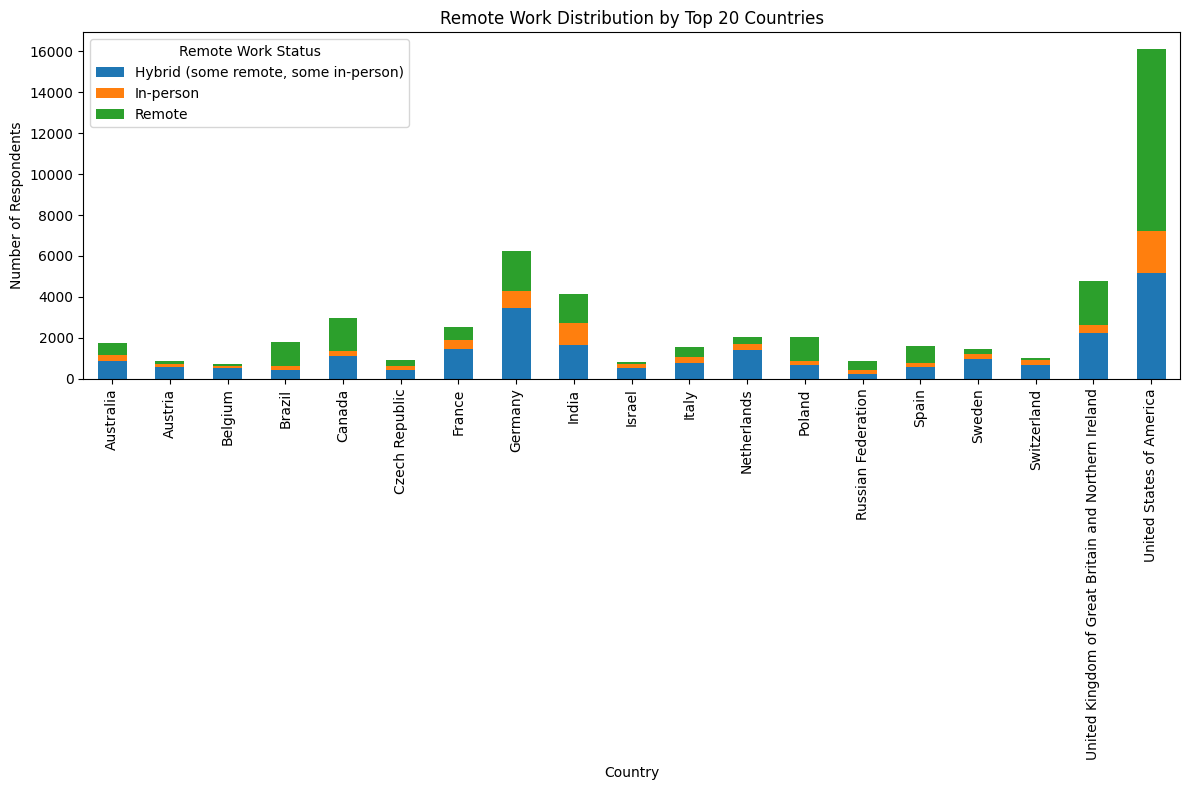

In [42]:


# Convert the filtered DataFrame to Pandas
df_top_20_pd = df_top_20.toPandas()

# Group by Country and RemoteWork and count the occurrences
remote_work_distribution = df_top_20_pd.groupby(['Country', 'RemoteWork']).size().reset_index(name='Count')

# Pivot the data for plotting
pivot_table = remote_work_distribution.pivot(index='Country', columns='RemoteWork', values='Count').fillna(0)

# Plot
plt.figure(figsize=(12, 8))
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Remote Work Distribution by Top 20 Countries')
plt.xlabel('Country')
plt.ylabel('Number of Respondents')
plt.xticks(rotation=90)
plt.legend(title='Remote Work Status')
plt.tight_layout()
plt.show()


In [43]:
remote_work_distribution

,Country,RemoteWork,Count
0,Australia,"Hybrid (some remote, some in-person)",885
1,Australia,In-person,254
2,Australia,Remote,630
3,Austria,"Hybrid (some remote, some in-person)",562
4,Austria,In-person,158
5,Austria,Remote,169
6,Belgium,"Hybrid (some remote, some in-person)",522
7,Belgium,In-person,109
8,Belgium,Remote,95
9,Brazil,"Hybrid (some remote, some in-person)",402


In [33]:
df_remote_cleaned.printSchema()

root
 |-- RemoteWork: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- ConvertedCompYearly: string (nullable = true)
 |-- DevType: string (nullable = true)
 |-- Age: string (nullable = true)



In [35]:
df_remote_cleaned.select('ConvertedCompYearly').show(10)

+-------------------+
|ConvertedCompYearly|
+-------------------+
|               NULL|
|             285000|
|             250000|
|             156000|
|              23456|
|              96828|
|             135000|
|              80000|
|              64254|
|               NULL|
+-------------------+
only showing top 10 rows



In [36]:
 #Convert 'ConvertedCompYearly' to float
df_remote_cleaned = df_remote_cleaned.withColumn("ConvertedCompYearly", col("ConvertedCompYearly").cast("float"))

# Drop rows with NULL in 'ConvertedCompYearly'
df_remote_cleaned = df_remote_cleaned.dropna(subset=["ConvertedCompYearly"])

In [37]:
# Group by RemoteWork and calculate average compensation
compensation_by_remote_work = df_remote_cleaned.groupBy("RemoteWork").agg(avg("ConvertedCompYearly").alias("AverageCompensation"))

#  Collect results into a Pandas DataFrame for plotting
compensation_by_remote_work_pd= compensation_by_remote_work.toPandas()

In [46]:
compensation_by_remote_work_pd

,RemoteWork,AverageCompensation
0,In-person,7.060951e+04
1,Remote,1.120075e+05
2,None,1.111153e+06
3,"Hybrid (some remote, some in-person)",1.002533e+05


In [38]:
# Group by Country and RemoteWork and calculate average compensation
compensation_by_country_remote_work = df_remote_cleaned.groupBy("Country", "RemoteWork").agg(avg("ConvertedCompYearly").alias("AverageCompensation"))

# Convert to Pandas DataFrame
compensation_by_country_remote_work_pd = compensation_by_country_remote_work.toPandas()


In [45]:
compensation_by_country_remote_work_pd

,Country,RemoteWork,AverageCompensation
0,Spain,In-person,36729.214953
1,Syrian Arab Republic,Remote,6727.142857
2,Sweden,Remote,75256.087209
3,Paraguay,Remote,43070.300000
4,Peru,"Hybrid (some remote, some in-person)",33260.000000
...,...,...,...
472,Isle of Man,Remote,41835.000000
473,Yemen,"Hybrid (some remote, some in-person)",13323.000000
474,Somalia,Remote,35000.000000
475,Saint Vincent and the Grenadines,Remote,40000.000000


/tmp/ipykernel_28406/422325839.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=compensation_by_remote_work_pd, x='RemoteWork', y='AverageCompensation', palette='viridis')


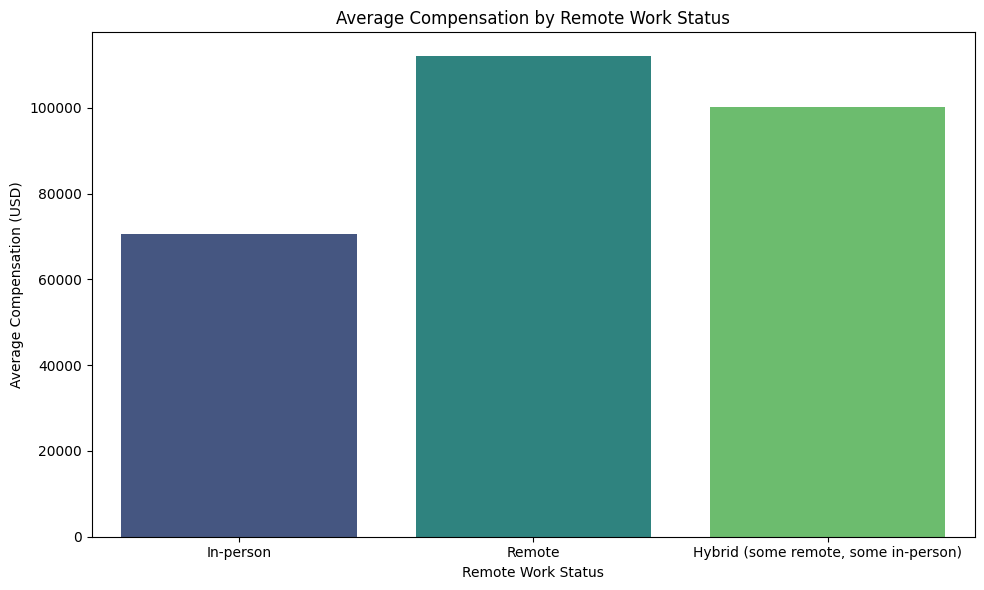

In [44]:


# Plot average compensation by RemoteWork
plt.figure(figsize=(10, 6))
sns.barplot(data=compensation_by_remote_work_pd, x='RemoteWork', y='AverageCompensation', palette='viridis')
plt.title('Average Compensation by Remote Work Status')
plt.xlabel('Remote Work Status')
plt.ylabel('Average Compensation (USD)')
plt.tight_layout()
plt.show()


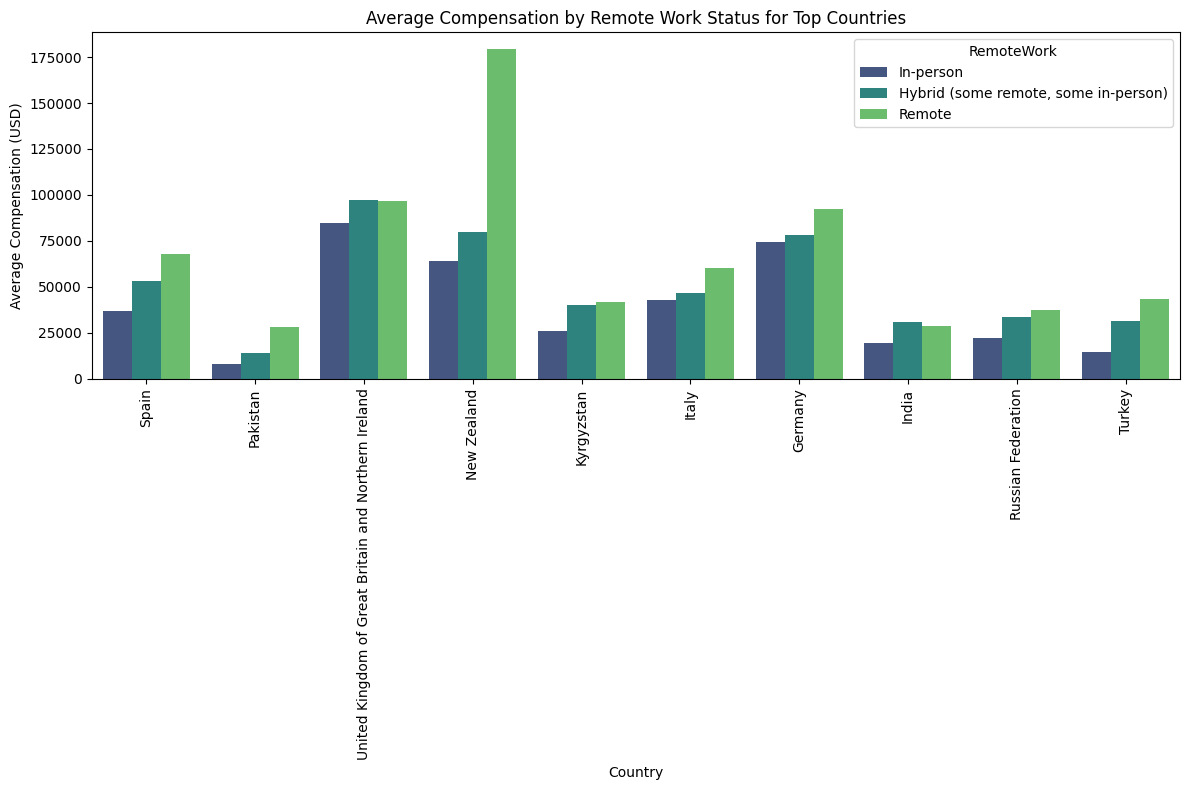

In [40]:
# Filter for top countries
top_countries = compensation_by_country_remote_work_pd['Country'].value_counts().head(10).index
df_top_countries = compensation_by_country_remote_work_pd[compensation_by_country_remote_work_pd['Country'].isin(top_countries)]

# Plot average compensation by RemoteWork for top countries
plt.figure(figsize=(12, 8))
sns.barplot(data=df_top_countries, x='Country', y='AverageCompensation', hue='RemoteWork', palette='viridis')
plt.title('Average Compensation by Remote Work Status for Top Countries')
plt.xlabel('Country')
plt.ylabel('Average Compensation (USD)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
